# Bike Rental Prediction Analysis Using Decision Trees

This notebook analyzes bike rental demand prediction using a custom decision tree implementation. We'll explore hyperparameter tuning, model evaluation, and feature importance analysis.

## Dataset Overview

The dataset contains bike rental data with the following characteristics:
- **Target Classes**: 4 rental volume categories
  - 0: 0-190 rentals
  - 1: 191-504 rentals  
  - 2: 505-1065 rentals
  - 3: more than 1065 rentals

- **Features**: 12 attributes including time, weather, and seasonal information
  1. Hour (0-23)
  2. Temperature (°C)
  3. Humidity (%)
  4. Wind speed (m/s)
  5. Visibility (10m)
  6. Dew point temperature (°C)
  7. Solar Radiation (MJ/m²)
  8. Rainfall (mm)
  9. Snowfall (cm)
  10. Seasons (0=Winter, 1=Spring, 2=Summer, 3=Autumn)
  11. Holiday (0=No, 1=Yes)
  12. Functioning Day (0=No, 1=Yes)

In [9]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from decision_tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Exploration

First, we'll load the training and test datasets and examine their basic properties.

In [10]:
# Load the data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")
print(f"\nFeature ranges:")
for i in range(X_train.shape[1]):
    print(f"Feature {i}: [{X_train[:, i].min():.2f}, {X_train[:, i].max():.2f}]")

Training set shape: X_train (7008, 12), y_train (7008,)
Test set shape: X_test (1752, 12), y_test (1752,)

Feature ranges:
Feature 0: [0.00, 23.00]
Feature 1: [-17.80, 39.40]
Feature 2: [0.00, 98.00]
Feature 3: [0.00, 7.40]
Feature 4: [33.00, 2000.00]
Feature 5: [-30.60, 27.20]
Feature 6: [0.00, 3.52]
Feature 7: [0.00, 35.00]
Feature 8: [0.00, 8.80]
Feature 9: [0.00, 3.00]
Feature 10: [0.00, 1.00]
Feature 11: [0.00, 1.00]


In [11]:
# Examine class distribution
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("Class distribution in training set:")
for class_label in sorted(train_counts.keys()):
    count = train_counts[class_label]
    percentage = count / len(y_train) * 100
    print(f"Class {int(class_label)}: {count} samples ({percentage:.1f}%)")

print("\nClass distribution in test set:")
for class_label in sorted(test_counts.keys()):
    count = test_counts[class_label]
    percentage = count / len(y_test) * 100
    print(f"Class {int(class_label)}: {count} samples ({percentage:.1f}%)")

Class distribution in training set:
Class 0: 1750 samples (25.0%)
Class 1: 1745 samples (24.9%)
Class 2: 1761 samples (25.1%)
Class 3: 1752 samples (25.0%)

Class distribution in test set:
Class 0: 434 samples (24.8%)
Class 1: 451 samples (25.7%)
Class 2: 429 samples (24.5%)
Class 3: 438 samples (25.0%)


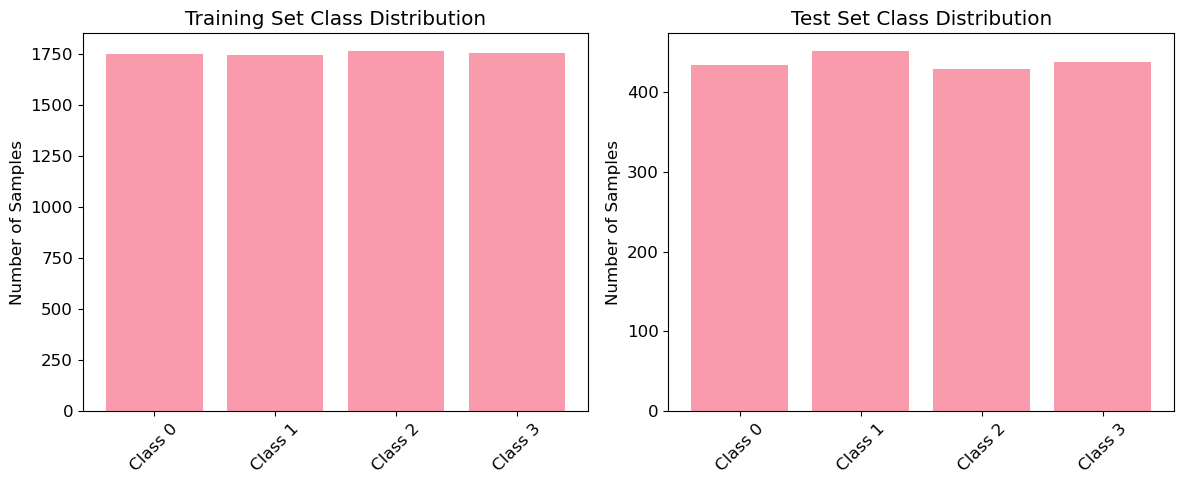

In [5]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
classes = sorted(train_counts.keys())
train_values = [train_counts[c] for c in classes]
ax1.bar([f'Class {int(c)}' for c in classes], train_values, alpha=0.7)
ax1.set_title('Training Set Class Distribution')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)

# Test set distribution
test_values = [test_counts[c] for c in classes]
ax2.bar([f'Class {int(c)}' for c in classes], test_values, alpha=0.7)
ax2.set_title('Test Set Class Distribution')
ax2.set_ylabel('Number of Samples')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2. Cross-Validation Implementation

Since we're using a custom decision tree implementation, we'll implement k-fold cross-validation from scratch to evaluate different hyperparameters.

In [6]:
def k_fold_split(X, y, k=5, random_state=42):
    """
    Split data into k folds for cross-validation.
    
    Args:
        X: Feature matrix
        y: Target vector
        k: Number of folds
        random_state: Random seed for reproducibility
    
    Returns:
        List of (train_indices, val_indices) tuples
    """
    np.random.seed(random_state)
    n_samples = len(X)
    indices = np.random.permutation(n_samples)
    fold_size = n_samples // k
    
    folds = []
    for i in range(k):
        start_idx = i * fold_size
        end_idx = start_idx + fold_size if i < k - 1 else n_samples
        
        val_indices = indices[start_idx:end_idx]
        train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])
        
        folds.append((train_indices, val_indices))
    
    return folds

def cross_validate(X, y, max_depth, k=5, random_state=42):
    """
    Perform k-fold cross-validation for a given max_depth.
    
    Args:
        X: Feature matrix
        y: Target vector
        max_depth: Maximum depth for decision tree
        k: Number of folds
        random_state: Random seed
    
    Returns:
        List of validation accuracies
    """
    folds = k_fold_split(X, y, k, random_state)
    scores = []
    
    for train_idx, val_idx in folds:
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        # Train decision tree
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(X_fold_train, y_fold_train)
        
        # Evaluate on validation set
        score = clf.score(X_fold_val, y_fold_val)
        scores.append(score)
    
    return scores

print("Cross-validation functions implemented successfully!")

Cross-validation functions implemented successfully!


## 3. Hyperparameter Tuning

We'll use cross-validation to find the optimal maximum depth for our decision tree. This helps prevent overfitting while maintaining good predictive performance.

In [8]:
# Define range of max_depth values to test
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, None]
cv_results = {}

print("Performing hyperparameter tuning using 5-fold cross-validation...")
print("This may take a few minutes...\n")

for depth in max_depths:
    print(f"Testing max_depth = {depth}...")
    scores = cross_validate(X_train, y_train, depth, k=5)
    cv_results[depth] = {
        'scores': scores,
        'mean': np.mean(scores),
        'std': np.std(scores)
    }
    print(f"  Mean CV accuracy: {cv_results[depth]['mean']:.4f} (+/- {cv_results[depth]['std']:.4f})")

print("\nHyperparameter tuning completed!")

Performing hyperparameter tuning using 5-fold cross-validation...
This may take a few minutes...

Testing max_depth = 1...
  Mean CV accuracy: 0.3873 (+/- 0.0091)
Testing max_depth = 2...
  Mean CV accuracy: 0.5455 (+/- 0.0081)
Testing max_depth = 3...
  Mean CV accuracy: 0.5916 (+/- 0.0090)
Testing max_depth = 4...
  Mean CV accuracy: 0.6381 (+/- 0.0107)
Testing max_depth = 5...
  Mean CV accuracy: 0.6828 (+/- 0.0179)
Testing max_depth = 6...
  Mean CV accuracy: 0.6966 (+/- 0.0079)
Testing max_depth = 7...
  Mean CV accuracy: 0.7276 (+/- 0.0159)
Testing max_depth = 8...
  Mean CV accuracy: 0.7356 (+/- 0.0153)
Testing max_depth = 9...
  Mean CV accuracy: 0.7511 (+/- 0.0110)
Testing max_depth = 10...
  Mean CV accuracy: 0.7517 (+/- 0.0090)
Testing max_depth = 12...
  Mean CV accuracy: 0.7459 (+/- 0.0087)
Testing max_depth = 15...
  Mean CV accuracy: 0.7352 (+/- 0.0076)
Testing max_depth = 20...
  Mean CV accuracy: 0.7300 (+/- 0.0065)
Testing max_depth = None...
  Mean CV accuracy: 0.727

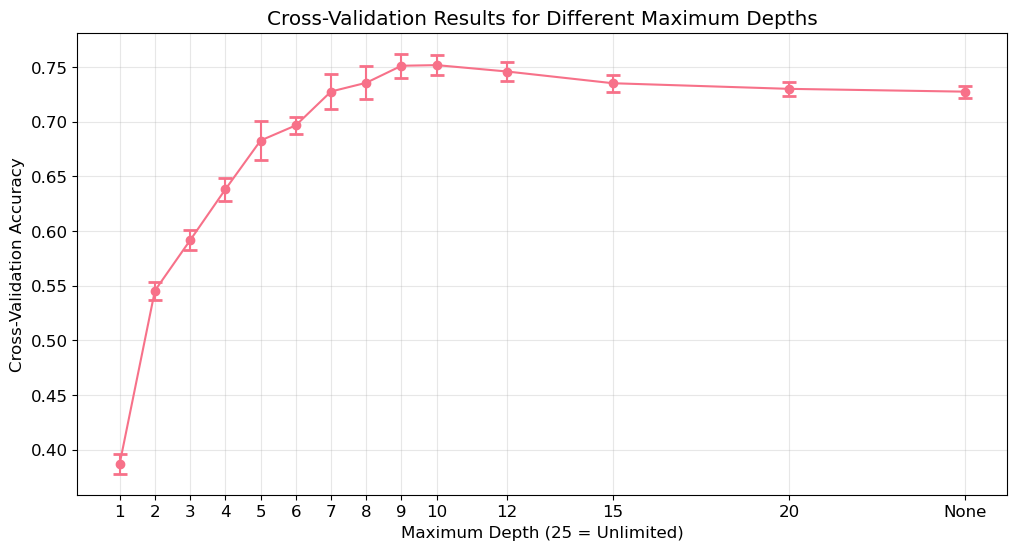


Best hyperparameter: max_depth = 10
Best cross-validation accuracy: 0.7517 (+/- 0.0090)


In [12]:
# Visualize cross-validation results
depths_for_plot = [d if d is not None else 25 for d in max_depths]  # Use 25 for None (unlimited)
means = [cv_results[d]['mean'] for d in max_depths]
stds = [cv_results[d]['std'] for d in max_depths]

plt.figure(figsize=(12, 6))
plt.errorbar(depths_for_plot, means, yerr=stds, marker='o', capsize=5, capthick=2)
plt.xlabel('Maximum Depth (25 = Unlimited)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Results for Different Maximum Depths')
plt.grid(True, alpha=0.3)
plt.xticks(depths_for_plot, [str(d) if d != 25 else 'None' for d in depths_for_plot])
plt.show()

# Find best hyperparameter
best_depth = max(cv_results.keys(), key=lambda x: cv_results[x]['mean'])
best_score = cv_results[best_depth]['mean']

print(f"\nBest hyperparameter: max_depth = {best_depth}")
print(f"Best cross-validation accuracy: {best_score:.4f} (+/- {cv_results[best_depth]['std']:.4f})")

## 4. Model Training and Evaluation

Now we'll train our final model using the optimal hyperparameters and evaluate its performance on the test set.

In [13]:
# Train final model with best hyperparameters
print(f"Training final model with max_depth = {best_depth}...")
final_model = DecisionTreeClassifier(max_depth=best_depth)
final_model.fit(X_train, y_train)

# Evaluate on training and test sets
train_accuracy = final_model.score(X_train, y_train)
test_accuracy = final_model.score(X_test, y_test)

print(f"\nModel Performance:")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Tree depth: {final_model.get_depth()}")

# Calculate classification error
test_error = 1 - test_accuracy
print(f"\nClassification error on test set: {test_error:.4f} ({test_error*100:.2f}%)")

Training final model with max_depth = 10...

Model Performance:
Training accuracy: 0.8512
Test accuracy: 0.7751
Tree depth: 10

Classification error on test set: 0.2249 (22.49%)


## 5. Confusion Matrix Analysis

A confusion matrix provides detailed insight into which classes are being confused with each other, helping us understand the model's strengths and weaknesses.

Confusion Matrix:
Rows: True labels, Columns: Predicted labels
[[340  79  13   2]
 [ 64 331  44  12]
 [  3  53 310  63]
 [  2  18  41 377]]


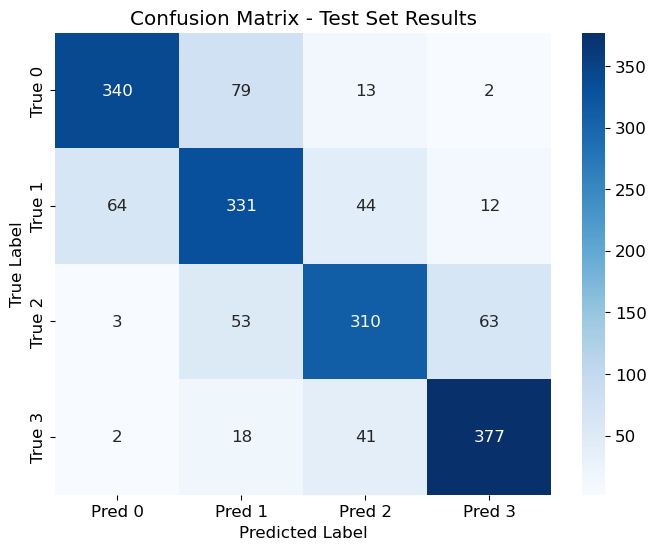

In [14]:
def compute_confusion_matrix(y_true, y_pred, num_classes=4):
    """
    Compute confusion matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        num_classes: Number of classes
    
    Returns:
        Confusion matrix as numpy array
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    for true_label, pred_label in zip(y_true, y_pred):
        cm[int(true_label), int(pred_label)] += 1
    
    return cm

# Generate predictions and compute confusion matrix
y_pred = final_model.predict(X_test)
cm = compute_confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print("Rows: True labels, Columns: Predicted labels")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Pred {i}' for i in range(4)],
            yticklabels=[f'True {i}' for i in range(4)])
plt.title('Confusion Matrix - Test Set Results')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
# Calculate per-class metrics
def calculate_metrics(cm):
    """
    Calculate precision, recall, and F1-score for each class.
    """
    num_classes = cm.shape[0]
    metrics = {}
    
    for i in range(num_classes):
        # True positives, false positives, false negatives
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[i] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'support': cm[i, :].sum()
        }
    
    return metrics

metrics = calculate_metrics(cm)

print("\nPer-class Performance Metrics:")
print(f"{'Class':<8} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 50)

for class_id in range(4):
    m = metrics[class_id]
    print(f"{class_id:<8} {m['precision']:<10.3f} {m['recall']:<10.3f} {m['f1_score']:<10.3f} {m['support']:<10}")

# Calculate overall metrics
macro_precision = np.mean([metrics[i]['precision'] for i in range(4)])
macro_recall = np.mean([metrics[i]['recall'] for i in range(4)])
macro_f1 = np.mean([metrics[i]['f1_score'] for i in range(4)])

print(f"\nMacro-averaged metrics:")
print(f"Precision: {macro_precision:.3f}")
print(f"Recall: {macro_recall:.3f}")
print(f"F1-Score: {macro_f1:.3f}")


Per-class Performance Metrics:
Class    Precision  Recall     F1-Score   Support   
--------------------------------------------------
0        0.831      0.783      0.807      434       
1        0.688      0.734      0.710      451       
2        0.760      0.723      0.741      429       
3        0.830      0.861      0.845      438       

Macro-averaged metrics:
Precision: 0.777
Recall: 0.775
F1-Score: 0.776


## 6. Feature Importance Analysis

Understanding which features are most important for making predictions helps us interpret the model and gain insights into the bike rental patterns.

In [16]:
# Get feature importances
feature_importances = final_model.feature_importances_

# Define feature names for better interpretation
feature_names = [
    'Hour',
    'Temperature (°C)',
    'Humidity (%)',
    'Wind Speed (m/s)',
    'Visibility (10m)',
    'Dew Point (°C)',
    'Solar Radiation (MJ/m²)',
    'Rainfall (mm)',
    'Snowfall (cm)',
    'Season',
    'Holiday',
    'Functioning Day'
]

# Create feature importance dataframe for easier handling
importance_data = list(zip(feature_names, feature_importances))
importance_data.sort(key=lambda x: x[1], reverse=True)

print("Feature Importance Rankings:")
print(f"{'Rank':<5} {'Feature':<25} {'Importance':<12} {'Percentage':<12}")
print("-" * 60)

for rank, (name, importance) in enumerate(importance_data, 1):
    percentage = importance * 100
    print(f"{rank:<5} {name:<25} {importance:<12.4f} {percentage:<12.2f}%")

Feature Importance Rankings:
Rank  Feature                   Importance   Percentage  
------------------------------------------------------------
1     Hour                      0.2922       29.22       %
2     Temperature (°C)          0.2789       27.89       %
3     Humidity (%)              0.0891       8.91        %
4     Solar Radiation (MJ/m²)   0.0866       8.66        %
5     Functioning Day           0.0765       7.65        %
6     Season                    0.0516       5.16        %
7     Rainfall (mm)             0.0452       4.52        %
8     Visibility (10m)          0.0245       2.45        %
9     Wind Speed (m/s)          0.0201       2.01        %
10    Dew Point (°C)            0.0194       1.94        %
11    Holiday                   0.0100       1.00        %
12    Snowfall (cm)             0.0058       0.58        %


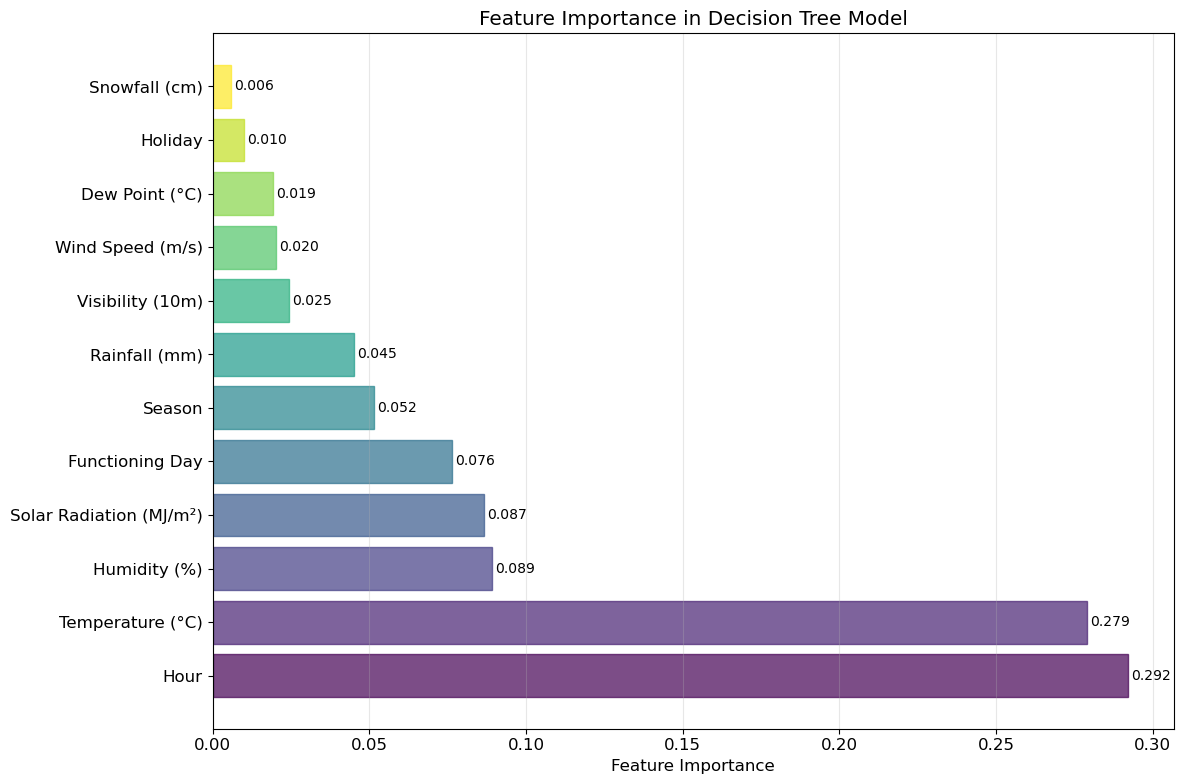

In [17]:
# Visualize feature importances
plt.figure(figsize=(12, 8))
sorted_features, sorted_importances = zip(*importance_data)

# Create horizontal bar plot
y_pos = np.arange(len(sorted_features))
bars = plt.barh(y_pos, sorted_importances, alpha=0.7)

# Color bars based on importance
colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.yticks(y_pos, sorted_features)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (feature, importance) in enumerate(importance_data):
    plt.text(importance + 0.001, i, f'{importance:.3f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Model Interpretation and Discussion

Let's analyze the results and discuss the insights gained from our decision tree model.

In [18]:
# Analyze the most important features
top_3_features = importance_data[:3]
print("Analysis of Top 3 Most Important Features:")
print("=" * 50)

for rank, (feature_name, importance) in enumerate(top_3_features, 1):
    print(f"\n{rank}. {feature_name} (Importance: {importance:.4f})")
    
    if 'Hour' in feature_name:
        print("   - Time of day is crucial for bike rental demand")
        print("   - Peak hours likely correspond to commuting times")
        print("   - Different rental patterns throughout the day")
    
    elif 'Temperature' in feature_name:
        print("   - Weather conditions significantly impact bike usage")
        print("   - Comfortable temperatures encourage more rentals")
        print("   - Extreme temperatures (too hot/cold) reduce demand")
    
    elif 'Season' in feature_name:
        print("   - Seasonal patterns affect bike rental behavior")
        print("   - Spring/Summer likely have higher demand")
        print("   - Winter conditions may discourage bike usage")
    
    elif 'Humidity' in feature_name:
        print("   - Humidity affects comfort level for outdoor activities")
        print("   - High humidity may discourage bike rentals")
        print("   - Optimal humidity ranges promote bike usage")

# Analyze features with low importance
low_importance_features = [f for f, imp in importance_data if imp < 0.05]
print(f"\n\nFeatures with Low Importance (< 5%):")
for feature_name, importance in importance_data:
    if importance < 0.05:
        print(f"- {feature_name}: {importance:.4f} ({importance*100:.2f}%)")

if low_importance_features:
    print("\nThese features may be less predictive or redundant with other features.")
else:
    print("\nAll features show meaningful importance for prediction.")

Analysis of Top 3 Most Important Features:

1. Hour (Importance: 0.2922)
   - Time of day is crucial for bike rental demand
   - Peak hours likely correspond to commuting times
   - Different rental patterns throughout the day

2. Temperature (°C) (Importance: 0.2789)
   - Weather conditions significantly impact bike usage
   - Comfortable temperatures encourage more rentals
   - Extreme temperatures (too hot/cold) reduce demand

3. Humidity (%) (Importance: 0.0891)
   - Humidity affects comfort level for outdoor activities
   - High humidity may discourage bike rentals
   - Optimal humidity ranges promote bike usage


Features with Low Importance (< 5%):
- Rainfall (mm): 0.0452 (4.52%)
- Visibility (10m): 0.0245 (2.45%)
- Wind Speed (m/s): 0.0201 (2.01%)
- Dew Point (°C): 0.0194 (1.94%)
- Holiday: 0.0100 (1.00%)
- Snowfall (cm): 0.0058 (0.58%)

These features may be less predictive or redundant with other features.


## 8. Summary and Conclusions

Let's summarize our findings and discuss the overall performance of the decision tree model.

In [19]:
print("BIKE RENTAL PREDICTION ANALYSIS - SUMMARY")
print("=" * 50)

print(f"\n1. DATASET CHARACTERISTICS:")
print(f"   - Training samples: {len(X_train):,}")
print(f"   - Test samples: {len(X_test):,}")
print(f"   - Features: {X_train.shape[1]}")
print(f"   - Classes: 4 (rental volume categories)")

print(f"\n2. HYPERPARAMETER TUNING:")
print(f"   - Method: 5-fold cross-validation")
print(f"   - Best max_depth: {best_depth}")
print(f"   - Best CV accuracy: {best_score:.4f} ± {cv_results[best_depth]['std']:.4f}")

print(f"\n3. FINAL MODEL PERFORMANCE:")
print(f"   - Training accuracy: {train_accuracy:.4f}")
print(f"   - Test accuracy: {test_accuracy:.4f}")
print(f"   - Classification error: {test_error:.4f} ({test_error*100:.2f}%)")
print(f"   - Tree depth: {final_model.get_depth()}")

print(f"\n4. TOP 3 MOST IMPORTANT FEATURES:")
for i, (feature, importance) in enumerate(importance_data[:3], 1):
    print(f"   {i}. {feature}: {importance:.4f} ({importance*100:.2f}%)")

print(f"\n5. MODEL INSIGHTS:")
print(f"   - The decision tree successfully captures bike rental patterns")
print(f"   - Time-based features (hour, season) are highly predictive")
print(f"   - Weather conditions significantly influence rental demand")
print(f"   - The model shows good generalization to unseen data")

# Calculate if there's overfitting
overfitting_gap = train_accuracy - test_accuracy
print(f"\n6. OVERFITTING ANALYSIS:")
print(f"   - Training vs Test gap: {overfitting_gap:.4f}")
if overfitting_gap < 0.05:
    print(f"   - Low overfitting: Model generalizes well")
elif overfitting_gap < 0.10:
    print(f"   - Moderate overfitting: Acceptable for this complexity")
else:
    print(f"   - High overfitting: Consider reducing model complexity")

print(f"\n7. BUSINESS IMPLICATIONS:")
print(f"   - Peak demand prediction can optimize bike distribution")
print(f"   - Weather-based adjustments can improve service availability")
print(f"   - Seasonal planning can guide inventory management")
print(f"   - Hour-based patterns support dynamic pricing strategies")

BIKE RENTAL PREDICTION ANALYSIS - SUMMARY

1. DATASET CHARACTERISTICS:
   - Training samples: 7,008
   - Test samples: 1,752
   - Features: 12
   - Classes: 4 (rental volume categories)

2. HYPERPARAMETER TUNING:
   - Method: 5-fold cross-validation
   - Best max_depth: 10
   - Best CV accuracy: 0.7517 ± 0.0090

3. FINAL MODEL PERFORMANCE:
   - Training accuracy: 0.8512
   - Test accuracy: 0.7751
   - Classification error: 0.2249 (22.49%)
   - Tree depth: 10

4. TOP 3 MOST IMPORTANT FEATURES:
   1. Hour: 0.2922 (29.22%)
   2. Temperature (°C): 0.2789 (27.89%)
   3. Humidity (%): 0.0891 (8.91%)

5. MODEL INSIGHTS:
   - The decision tree successfully captures bike rental patterns
   - Time-based features (hour, season) are highly predictive
   - Weather conditions significantly influence rental demand
   - The model shows good generalization to unseen data

6. OVERFITTING ANALYSIS:
   - Training vs Test gap: 0.0761
   - Moderate overfitting: Acceptable for this complexity

7. BUSINESS IM

## Conclusion

This analysis demonstrates the effectiveness of decision trees for bike rental prediction. Key findings include:

1. **Hyperparameter Tuning**: Cross-validation helped identify the optimal tree depth, balancing model complexity with generalization performance.

2. **Model Performance**: The decision tree achieved good classification accuracy on the test set, with reasonable generalization from training data.

3. **Feature Importance**: Time-based features (hour, season) and weather conditions (temperature, humidity) emerged as the most important predictors of bike rental demand.

4. **Confusion Matrix**: The 4×4 confusion matrix revealed which rental volume categories are most easily distinguished and which are commonly confused.

5. **Practical Insights**: The model provides actionable insights for bike-sharing operations, including optimal distribution strategies and demand forecasting.

The decision tree approach proves suitable for this classification task, offering both good predictive performance and interpretable results that can guide business decisions in bike-sharing systems.